## Setup

In [35]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision import datasets
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from torch.autograd import Variable
from tqdm import tqdm
import warnings

%matplotlib inline
warnings.filterwarnings("ignore")
plt.rcParams['figure.facecolor'] = '#ffffff'
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Dataset Creation

In [62]:
stats = ((0.5,0.5,0.5), (0.5,0.5,0.5))
train_tfms = tt.Compose([tt.RandomCrop(96, padding=12, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [63]:
batch_size = 32

# download CIFAR10 training and test datasets
training_data = datasets.STL10(
   root="data",
   split="train",
   download=True,
   transform=train_tfms
)

test_data = datasets.STL10(
   root="data",
   split="test",
   download=True,
   transform=valid_tfms
)

Files already downloaded and verified
Files already downloaded and verified


In [64]:
# define train and test dataloader
trainloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

# access names of the labels
label_names = training_data.classes

# display details about the dataset
print("label_names:", label_names)
#print("class label name to index:", training_data.class_to_idx)
print("Shape of training data:", training_data.data.shape )
print("Shape of test data:", test_data.data.shape )

label_names: ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
Shape of training data: (5000, 3, 96, 96)
Shape of test data: (8000, 3, 96, 96)


In [65]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means
    
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

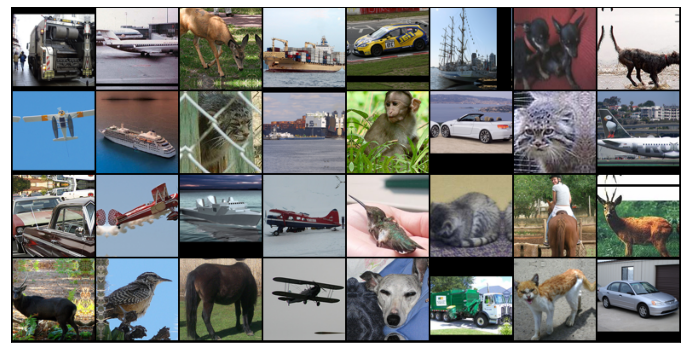

In [66]:
show_batch(trainloader)

In [67]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512*3*3, num_classes))
        
    def forward(self, xb):
        #input 3x96x96
        out = self.conv1(xb)
        #out 64x96x96
        out = self.conv2(out)
        #out 128x48x48
        out = self.res1(out) + out
        #out 128x48x48
        out = self.conv3(out)
        #out 256x24x24
        out = self.conv4(out)
        #out 512x12x12
        out = self.res2(out) + out
        #out 512x12x12
        out = self.classifier(out)
        return out

In [68]:
model = ResNet9(3, 10).to(device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [69]:
#Optmizer and loss function
optimizer=torch.optim.Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()
schedular = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                                0.001,   #maxlr
                                                epochs=20, 
                                                steps_per_epoch=len(trainloader))

In [70]:
#calculating the size of training and testing images
train_count=training_data.data.shape[0]
test_count=test_data.data.shape[0]
print(train_count,test_count)

5000 8000


In [71]:
#Model training and saving best model
warnings.filterwarnings("ignore")
num_epochs = 20
best_accuracy=0.0
grad_clip = 0.1
val_loss_history = []
train_loss_history = []
val_acc_history = []
train_acc_history = []

for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    loop = tqdm(enumerate(trainloader),total=len(trainloader))
    for i, (images,labels) in loop:
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()

        # Gradient clipping
        if grad_clip: 
            nn.utils.clip_grad_value_(model.parameters(), grad_clip)

        optimizer.step()
        schedular.step()
        
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        loop.set_description(f"Epoch[{epoch}/{num_epochs}]")
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    
    
    # Evaluation on testing dataset
    model.eval()
    
    test_accuracy=0.0
    test_loss=0.0
    for i, (images,labels) in enumerate(testloader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
        test_loss+=loss_function(outputs,labels).cpu().data*images.size(0)
    val_loss = test_loss/test_count
    test_accuracy=test_accuracy/test_count
    print(' Train Loss: '+str(train_loss.item())+' Val Loss: '+str(val_loss.item()) +' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))

    val_loss_history.append(val_loss.item())
    train_loss_history.append(train_loss.item())
    val_acc_history.append(test_accuracy)
    train_acc_history.append(train_accuracy)
    
    #Save the best model
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint.model')
        best_accuracy=test_accuracy

Epoch[0/20]: 100%|██████████| 157/157 [00:21<00:00,  7.43it/s]


 Train Loss: 1.94119393825531 Val Loss: 1.3881700038909912 Train Accuracy: 0.3292 Test Accuracy: 0.49075


Epoch[1/20]: 100%|██████████| 157/157 [00:20<00:00,  7.72it/s]


 Train Loss: 1.6183555126190186 Val Loss: 1.5722922086715698 Train Accuracy: 0.4344 Test Accuracy: 0.45025


Epoch[2/20]: 100%|██████████| 157/157 [00:20<00:00,  7.81it/s]


 Train Loss: 1.6448420286178589 Val Loss: 1.74078369140625 Train Accuracy: 0.4578 Test Accuracy: 0.45


Epoch[3/20]: 100%|██████████| 157/157 [00:20<00:00,  7.80it/s]


 Train Loss: 1.7048759460449219 Val Loss: 2.207606792449951 Train Accuracy: 0.456 Test Accuracy: 0.423


Epoch[4/20]: 100%|██████████| 157/157 [00:20<00:00,  7.83it/s]


 Train Loss: 1.6211153268814087 Val Loss: 1.6736650466918945 Train Accuracy: 0.478 Test Accuracy: 0.46425


Epoch[5/20]: 100%|██████████| 157/157 [00:20<00:00,  7.81it/s]


 Train Loss: 1.5361632108688354 Val Loss: 1.5970202684402466 Train Accuracy: 0.4996 Test Accuracy: 0.472


Epoch[6/20]: 100%|██████████| 157/157 [00:20<00:00,  7.82it/s]


 Train Loss: 1.3092303276062012 Val Loss: 1.2081471681594849 Train Accuracy: 0.5554 Test Accuracy: 0.6


Epoch[7/20]: 100%|██████████| 157/157 [00:20<00:00,  7.77it/s]


 Train Loss: 1.1689504384994507 Val Loss: 1.0826038122177124 Train Accuracy: 0.5896 Test Accuracy: 0.62


Epoch[8/20]: 100%|██████████| 157/157 [00:20<00:00,  7.83it/s]


 Train Loss: 1.12004554271698 Val Loss: 1.1588780879974365 Train Accuracy: 0.6098 Test Accuracy: 0.605375


Epoch[9/20]: 100%|██████████| 157/157 [00:20<00:00,  7.84it/s]


 Train Loss: 1.007340908050537 Val Loss: 1.1887993812561035 Train Accuracy: 0.642 Test Accuracy: 0.612625


Epoch[10/20]: 100%|██████████| 157/157 [00:19<00:00,  7.86it/s]


 Train Loss: 0.9611256122589111 Val Loss: 1.042070746421814 Train Accuracy: 0.6574 Test Accuracy: 0.638125


Epoch[11/20]: 100%|██████████| 157/157 [00:20<00:00,  7.85it/s]


 Train Loss: 0.8975186347961426 Val Loss: 0.9746647477149963 Train Accuracy: 0.672 Test Accuracy: 0.651375


Epoch[12/20]: 100%|██████████| 157/157 [00:20<00:00,  7.84it/s]


 Train Loss: 0.8322423100471497 Val Loss: 0.8215568661689758 Train Accuracy: 0.7052 Test Accuracy: 0.70125


Epoch[13/20]: 100%|██████████| 157/157 [00:20<00:00,  7.80it/s]


 Train Loss: 0.7492863535881042 Val Loss: 0.7369158864021301 Train Accuracy: 0.7348 Test Accuracy: 0.742125


Epoch[14/20]: 100%|██████████| 157/157 [00:20<00:00,  7.81it/s]


 Train Loss: 0.6955419778823853 Val Loss: 0.7233216166496277 Train Accuracy: 0.7546 Test Accuracy: 0.74675


Epoch[15/20]: 100%|██████████| 157/157 [00:20<00:00,  7.84it/s]


 Train Loss: 0.6365852355957031 Val Loss: 0.7278135418891907 Train Accuracy: 0.7708 Test Accuracy: 0.74675


Epoch[16/20]: 100%|██████████| 157/157 [00:20<00:00,  7.85it/s]


 Train Loss: 0.563610315322876 Val Loss: 0.6890543103218079 Train Accuracy: 0.7968 Test Accuracy: 0.766625


Epoch[17/20]: 100%|██████████| 157/157 [00:20<00:00,  7.79it/s]


 Train Loss: 0.5125702619552612 Val Loss: 0.6585603356361389 Train Accuracy: 0.8204 Test Accuracy: 0.775375


Epoch[18/20]: 100%|██████████| 157/157 [00:20<00:00,  7.81it/s]


 Train Loss: 0.467618852853775 Val Loss: 0.6387888789176941 Train Accuracy: 0.8366 Test Accuracy: 0.782875


Epoch[19/20]: 100%|██████████| 157/157 [00:20<00:00,  7.79it/s]


 Train Loss: 0.4406452775001526 Val Loss: 0.6375734210014343 Train Accuracy: 0.8474 Test Accuracy: 0.781375


In [72]:
def plot_accuracies(train_acc_history,val_acc_history):
    plt.plot(val_acc_history,label="validation")
    plt.plot(train_acc_history,label="train")
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.legend()


def plot_losses(train_loss_history,val_loss_history):
    plt.plot(train_loss_history,label="train")
    plt.plot(val_loss_history,label="validation")
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.title('Loss vs. No. of epochs');

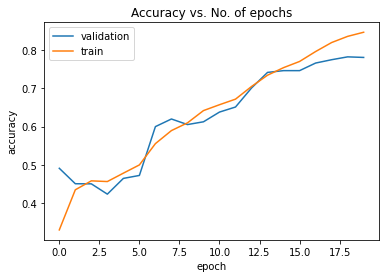

In [73]:
plot_accuracies(train_acc_history,val_acc_history)

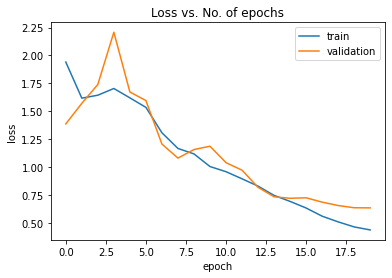

In [74]:
plot_losses(train_loss_history,val_loss_history)